In [1]:
import numpy as np
import PIL.Image as pil
import matplotlib as mpl
import matplotlib.cm as cm

import mxnet as mx
from mxnet.gluon.data.vision import transforms
import gluoncv
from gluoncv.model_zoo.monodepthv2.layers import disp_to_depth

In [5]:
# using cpu
ctx = mx.cpu(0)

## Prepare the image

In [6]:
url = 'https://raw.githubusercontent.com/KuangHaofei/GluonCV_Test/master/monodepthv2/tutorials/test_img.png'
filename = 'test_img.png'
gluoncv.utils.download(url, filename, True)

729KB [00:00, 1062.25KB/s]                        


'test_img.png'

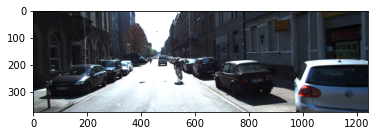

In [7]:
img = pil.open(filename).convert('RGB')

from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()

## Transformation

In [8]:
original_width, original_height = img.size
feed_height = 192
feed_width = 640

img = img.resize((feed_width, feed_height), pil.LANCZOS)
img = transforms.ToTensor()(mx.nd.array(img)).expand_dims(0).as_in_context(context=ctx)

## Loading Model 

In [9]:
model = gluoncv.model_zoo.get_model('monodepth2_resnet18_kitti_stereo_640x192', pretrained_base=False, ctx=ctx, pretrained=True)

## Prediction

In [10]:
outputs = model.predict(img)
disp = outputs[("disp", 0)]
disp_resized = mx.nd.contrib.BilinearResize2D(disp, height=original_height, width=original_width)

In [11]:
scaled_disp, _ = disp_to_depth(disp_resized, 0.1, 100)  # up-to-scale

## Visualization

In [12]:
disp_resized_np = disp_resized.squeeze().as_in_context(mx.cpu()).asnumpy()
vmax = np.percentile(disp_resized_np, 95)
normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
colormapped_im = (mapper.to_rgba(disp_resized_np)[:, :, :3] * 255).astype(np.uint8)
im = pil.fromarray(colormapped_im)
im.save('test_output.jpg')

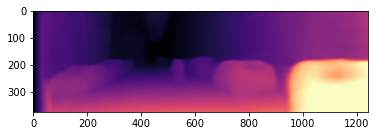

In [13]:
plt.imshow(im)
plt.show()